In [ ]:
import sys
assert sys.version_info >= (3, 7)
import sklearn
assert sklearn.__version__ >= "1.0.1"
import tensorflow as tf
assert tf.__version__ >= "2.8.0"
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)



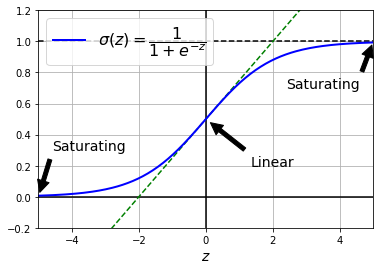

In [ ]:
#vanishing/exploding gradients problem
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

plt.show()
#backprop algo goes from output from input upgrading the weights 
# - vanishing gradients
# gradients get smaller and smaller as the algo goes down to lower layers
# so the gradient descendent does not change the lowest layers
# - exploding gradients
# is the opposite gradients gets bigger

#looking at logistic function, with large inputs (pos or neg) they saturate to 0 or 1


In [ ]:
#xavier and he inizialization
dense = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal")
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

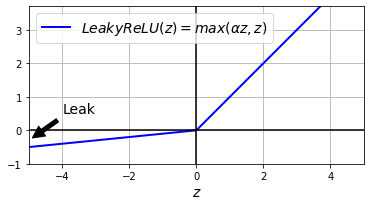

In [ ]:
#leaky relu, does not saturate, alpha define the leaks, the slope of the function
# to solve the problem of dying ReLU, neurons that only outputs 0
# in this way neurons never die
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

#there is also randomized leaky ReLU (RReLU) where alpha is taken random
#there is also Parametric ReLU, where alpha can be trained during the training


In [7]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])


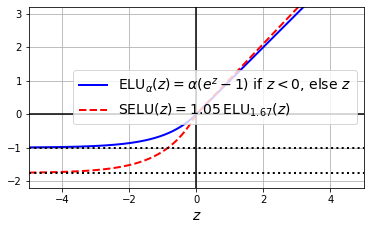

In [8]:
#exponential linear unit
#it takes negative values when z<0, helps with vanishing gradients
#avoid dead neurons
#if alpha is 1 the function is smooth everywhere
# buuuuuuuuut is slower than ReLU
# buuuuuuuuuuuuuut it converge faster
# buuuuuuuuuuuuuuuuuut it's still slower

dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

#there is also the Scaled ELU, SELU, if you use SELU the network will self-normalize
#the output tends to preserve a mean of 0 and dev std of 1
#it requires:
# - input features must be standardized
# - every hidden layer must be inizialized with lecun normal initialization
# - network architecture must be sequential
# - layers must be dense
# SELU > ELU > leaky ReLU > ReLU > tanh > logistic


#SELU
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)
  
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

In [9]:
#lets create a neural net for mnist and selu
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds


history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

4431872/4422102 [==============================] - 0s 0us/step
Epoch 1/5
1719/1719 [==============================] - 32s 16ms/step - loss: 1.1585 - accuracy: 0.5627 - val_loss: 0.8144 - val_accuracy: 0.6980
Epoch 2/5
1719/1719 [==============================] - 27s 16ms/step - loss: 0.7087 - accuracy: 0.7379 - val_loss: 0.6912 - val_accuracy: 0.7590
Epoch 3/5
1719/1719 [==============================] - 28s 16ms/step - loss: 0.6082 - accuracy: 0.7754 - val_loss: 0.5523 - val_accuracy: 0.8050
Epoch 4/5
1719/1719 [==============================] - 27s 16ms/step - loss: 0.5646 - accuracy: 0.7961 - val_loss: 0.5278 - val_accuracy: 0.8174
Epoch 5/5
1719/1719 [==============================] - 27s 16ms/step - loss: 0.6511 - accuracy: 0.7689 - val_loss: 0.7205 - val_accuracy: 0.7376


In [10]:
#now lets try with elu
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))



Epoch 1/5
1719/1719 [==============================] - 30s 15ms/step - loss: 1.6528 - accuracy: 0.3322 - val_loss: 1.0960 - val_accuracy: 0.5740
Epoch 2/5
1719/1719 [==============================] - 26s 15ms/step - loss: 1.1456 - accuracy: 0.5109 - val_loss: 1.6676 - val_accuracy: 0.3612
Epoch 3/5
1719/1719 [==============================] - 26s 15ms/step - loss: 0.8954 - accuracy: 0.6323 - val_loss: 0.7768 - val_accuracy: 0.6834
Epoch 4/5
1719/1719 [==============================] - 26s 15ms/step - loss: 0.8099 - accuracy: 0.6704 - val_loss: 0.9092 - val_accuracy: 0.6188
Epoch 5/5
1719/1719 [==============================] - 26s 15ms/step - loss: 0.8406 - accuracy: 0.6648 - val_loss: 1.2525 - val_accuracy: 0.5452


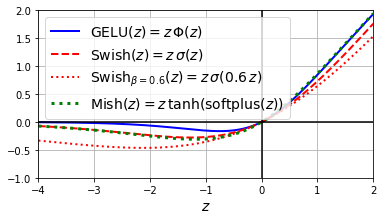

In [11]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

plt.show()

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [13]:
#batch normalization add an operation before or after activation function of an hidden layer
#this operation zero center and normalize each input, then scales and shifts the result
# using 2 parameters per vector, one for scaling and one for shifting

#the operation let learn the optimal scale and shift for each layer input
# there is no need to standardize the input since the BN layer will do it

# good for training but what about test?
# compute statistics over a batch (test set) is unreliable, solutions:
# - compute meand and devstd at the end of the training and use this values in test phase
# - moving average of the layer's input

#in a batch layer there are 4 parameters:
# gamma for the scale, beta for the offset, mean and devstd

#finally BN acts as a regularizer (reducing the need for DROPOUT!!!!)

#it adds more complexity to the model, there is an extra operation
# you can fuse the BN layer with the previous after training, updating weights and biases
# directly to produce the appropriate scale and offset
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.summary()
#mean and dev are non trainable parameters beacause there are not affected by back propagation


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [14]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [15]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5558 - accuracy: 0.8096 - val_loss: 0.4009 - val_accuracy: 0.8548
Epoch 2/2
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4081 - accuracy: 0.8561 - val_loss: 0.3676 - val_accuracy: 0.8658


In [16]:
# Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a BatchNormalization layer does not need
# to have bias terms, since the BatchNormalization layer some as well, it would be a waste of parameters, so you can set use_bias=False when creating those layers:
tf.keras.backend.clear_session()
tf.random.set_seed(42)


In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [18]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6061 - accuracy: 0.7992 - val_loss: 0.4306 - val_accuracy: 0.8438
Epoch 2/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4273 - accuracy: 0.8502 - val_loss: 0.3751 - val_accuracy: 0.8634


In [19]:
#gradient clipping
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)


In [20]:
#reusing pretrained models

#split fashion mnist, all items except for t-shirt, pullover and tops (0 and 2) and the rest
#train a model with 8 classes and try to reuse it for the rest

#using dense layer only patterns that occurs at the exact same location can be useful
# conversely convulutional layer can reuse much more information

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 5s 3ms/step - loss: 1.1386 - accuracy: 0.6260 - val_loss: 0.7101 - val_accuracy: 0.7603
Epoch 2/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.6221 - accuracy: 0.7911 - val_loss: 0.5293 - val_accuracy: 0.8318
Epoch 3/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.5016 - accuracy: 0.8394 - val_loss: 0.4514 - val_accuracy: 0.8584
Epoch 4/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.4381 - accuracy: 0.8583 - val_loss: 0.4055 - val_accuracy: 0.8669
Epoch 5/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.3979 - accuracy: 0.8693 - val_loss: 0.3748 - val_accuracy: 0.8706
Epoch 6/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.3693 - accuracy: 0.8782 - val_loss: 0.3538 - val_accuracy: 0.8784
Epoch 7/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.3487 - accuracy: 0.8824 - val_loss: 0.3376 - val_accuracy:

In [21]:
#lets try t evaluate B without reusing A
tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)
#91.85 accuracy without reusing A

Epoch 1/20
7/7 [==============================] - 1s 48ms/step - loss: 0.7167 - accuracy: 0.5450 - val_loss: 0.7052 - val_accuracy: 0.5272
Epoch 2/20
7/7 [==============================] - 0s 17ms/step - loss: 0.6805 - accuracy: 0.5800 - val_loss: 0.6758 - val_accuracy: 0.6004
Epoch 3/20
7/7 [==============================] - 0s 15ms/step - loss: 0.6532 - accuracy: 0.6650 - val_loss: 0.6530 - val_accuracy: 0.6746
Epoch 4/20
7/7 [==============================] - 0s 18ms/step - loss: 0.6289 - accuracy: 0.7150 - val_loss: 0.6317 - val_accuracy: 0.7517
Epoch 5/20
7/7 [==============================] - 0s 18ms/step - loss: 0.6079 - accuracy: 0.7800 - val_loss: 0.6105 - val_accuracy: 0.8091
Epoch 6/20
7/7 [==============================] - 0s 20ms/step - loss: 0.5866 - accuracy: 0.8400 - val_loss: 0.5913 - val_accuracy: 0.8447
Epoch 7/20
7/7 [==============================] - 0s 17ms/step - loss: 0.5670 - accuracy: 0.8850 - val_loss: 0.5728 - val_accuracy: 0.8833
Epoch 8/20
7/7 [===========

[0.43168652057647705, 0.9185000061988831]

In [22]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))
# Note that model_B_on_A and model_A actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build
# model_B_on_A on top of a clone of model_A:
tf.random.set_seed(42)
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

# extra code – creating model_B_on_A just like in the previous cell
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [23]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 36ms/step - loss: 1.7918 - accuracy: 0.5550 - val_loss: 1.3344 - val_accuracy: 0.5074
Epoch 2/4
7/7 [==============================] - 0s 12ms/step - loss: 1.1258 - accuracy: 0.5350 - val_loss: 0.9221 - val_accuracy: 0.4807
Epoch 3/4
7/7 [==============================] - 0s 16ms/step - loss: 0.8862 - accuracy: 0.4950 - val_loss: 0.8288 - val_accuracy: 0.4827
Epoch 4/4
7/7 [==============================] - 0s 14ms/step - loss: 0.8227 - accuracy: 0.5250 - val_loss: 0.7815 - val_accuracy: 0.4975
Epoch 1/16
7/7 [==============================] - 1s 38ms/step - loss: 0.7367 - accuracy: 0.6000 - val_loss: 0.6386 - val_accuracy: 0.6904
Epoch 2/16
7/7 [==============================] - 0s 14ms/step - loss: 0.6069 - accuracy: 0.7600 - val_loss: 0.5293 - val_accuracy: 0.8229
Epoch 3/16
7/7 [==============================] - 0s 13ms/step - loss: 0.5001 - accuracy: 0.8350 - val_loss: 0.4748 - val_accuracy: 0.8190
Epoch 4/16
7/7 [===============

In [24]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 6ms/step - loss: 0.2544 - accuracy: 0.9380


[0.2544202208518982, 0.9380000233650208]

In [25]:
#how much the error drops?
1 - (100 - 93.85) / (100 - 91.85)

0.24539877300613477

In [26]:
#faster optimizers

#code to test optimizer for mnist
def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [27]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
history_sgd = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6875 - accuracy: 0.7680 - val_loss: 0.4955 - val_accuracy: 0.8184
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4621 - accuracy: 0.8378 - val_loss: 0.4415 - val_accuracy: 0.8414
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4181 - accuracy: 0.8521 - val_loss: 0.4196 - val_accuracy: 0.8522
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3905 - accuracy: 0.8626 - val_loss: 0.3807 - val_accuracy: 0.8610
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3688 - accuracy: 0.8691 - val_loss: 0.3662 - val_accuracy: 0.8656
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3553 - accuracy: 0.8729 - val_loss: 0.3669 - val_accuracy: 0.8718
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3388 - accuracy: 0.8777 - val_loss: 0.3601 - val_accuracy:

In [28]:
#momentum optimization
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
history_momentum = build_and_train_model(optimizer)


Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6875 - accuracy: 0.7680 - val_loss: 0.4955 - val_accuracy: 0.8184
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4621 - accuracy: 0.8378 - val_loss: 0.4415 - val_accuracy: 0.8414
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4181 - accuracy: 0.8521 - val_loss: 0.4196 - val_accuracy: 0.8522
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3905 - accuracy: 0.8626 - val_loss: 0.3807 - val_accuracy: 0.8610
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3688 - accuracy: 0.8691 - val_loss: 0.3662 - val_accuracy: 0.8656
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3553 - accuracy: 0.8729 - val_loss: 0.3669 - val_accuracy: 0.8718
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3388 - accuracy: 0.8777 - val_loss: 0.3601 - val_accuracy:

In [29]:
#nesterov
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6777 - accuracy: 0.7711 - val_loss: 0.4796 - val_accuracy: 0.8260
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4570 - accuracy: 0.8398 - val_loss: 0.4358 - val_accuracy: 0.8396
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4140 - accuracy: 0.8537 - val_loss: 0.4017 - val_accuracy: 0.8568
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3882 - accuracy: 0.8627 - val_loss: 0.3769 - val_accuracy: 0.8618
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3668 - accuracy: 0.8695 - val_loss: 0.3677 - val_accuracy: 0.8640
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3529 - accuracy: 0.8730 - val_loss: 0.3681 - val_accuracy: 0.8690
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3373 - accuracy: 0.8782 - val_loss: 0.3660 - val_accuracy:

In [30]:
#adagrad
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.0003 - accuracy: 0.6822 - val_loss: 0.6876 - val_accuracy: 0.7744
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6389 - accuracy: 0.7904 - val_loss: 0.5837 - val_accuracy: 0.8050
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5682 - accuracy: 0.8104 - val_loss: 0.5379 - val_accuracy: 0.8154
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5317 - accuracy: 0.8215 - val_loss: 0.5134 - val_accuracy: 0.8246
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5076 - accuracy: 0.8296 - val_loss: 0.4937 - val_accuracy: 0.8286
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4905 - accuracy: 0.8338 - val_loss: 0.4821 - val_accuracy: 0.8312
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4776 - accuracy: 0.8371 - val_loss: 0.4704 - val_accuracy:

In [31]:
#rmsprop
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5142 - accuracy: 0.8139 - val_loss: 0.4198 - val_accuracy: 0.8342
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3936 - accuracy: 0.8585 - val_loss: 0.4590 - val_accuracy: 0.8294
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3698 - accuracy: 0.8699 - val_loss: 0.4041 - val_accuracy: 0.8654
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3648 - accuracy: 0.8737 - val_loss: 0.3815 - val_accuracy: 0.8744
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3618 - accuracy: 0.8747 - val_loss: 0.3823 - val_accuracy: 0.8676
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3592 - accuracy: 0.8776 - val_loss: 0.4619 - val_accuracy: 0.8630
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3572 - accuracy: 0.8793 - val_loss: 0.4592 - val_accuracy:

In [32]:
#adam
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)
history_adam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4949 - accuracy: 0.8220 - val_loss: 0.4110 - val_accuracy: 0.8428
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3747 - accuracy: 0.8627 - val_loss: 0.4085 - val_accuracy: 0.8412
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3364 - accuracy: 0.8757 - val_loss: 0.3534 - val_accuracy: 0.8716
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3138 - accuracy: 0.8835 - val_loss: 0.3536 - val_accuracy: 0.8724
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2951 - accuracy: 0.8896 - val_loss: 0.3256 - val_accuracy: 0.8814
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2826 - accuracy: 0.8946 - val_loss: 0.3586 - val_accuracy: 0.8758
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2702 - accuracy: 0.8984 - val_loss: 0.3509 - val_accuracy:

In [33]:
#adamax
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)
history_adamax = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5326 - accuracy: 0.8157 - val_loss: 0.4385 - val_accuracy: 0.8354
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3940 - accuracy: 0.8602 - val_loss: 0.3913 - val_accuracy: 0.8548
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3562 - accuracy: 0.8711 - val_loss: 0.3675 - val_accuracy: 0.8660
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3323 - accuracy: 0.8802 - val_loss: 0.3476 - val_accuracy: 0.8722
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3115 - accuracy: 0.8865 - val_loss: 0.3331 - val_accuracy: 0.8774
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2989 - accuracy: 0.8910 - val_loss: 0.3325 - val_accuracy: 0.8796
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2844 - accuracy: 0.8951 - val_loss: 0.3468 - val_accuracy:

In [34]:
#nadam
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)
history_nadam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 9s 4ms/step - loss: 0.4826 - accuracy: 0.8284 - val_loss: 0.4092 - val_accuracy: 0.8456
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3621 - accuracy: 0.8670 - val_loss: 0.3693 - val_accuracy: 0.8606
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3271 - accuracy: 0.8790 - val_loss: 0.3640 - val_accuracy: 0.8684
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3050 - accuracy: 0.8883 - val_loss: 0.3376 - val_accuracy: 0.8760
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2886 - accuracy: 0.8912 - val_loss: 0.3271 - val_accuracy: 0.8800
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2761 - accuracy: 0.8974 - val_loss: 0.3413 - val_accuracy: 0.8766
Epoch 7/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2648 - accuracy: 0.9013 - val_loss: 0.3347 - val_accuracy:

In [35]:
#adamW
if "google.colab" in sys.modules:
    %pip install -q -U tensorflow-addons
import tensorflow_addons as tfa

optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                 beta_1=0.9, beta_2=0.999)

history_adamw = build_and_train_model(optimizer)

     |████████████████████████████████| 1.1 MB 10.6 MB/s 
Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4945 - accuracy: 0.8226 - val_loss: 0.4346 - val_accuracy: 0.8322
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3731 - accuracy: 0.8632 - val_loss: 0.3951 - val_accuracy: 0.8482
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3391 - accuracy: 0.8754 - val_loss: 0.3587 - val_accuracy: 0.8736
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3159 - accuracy: 0.8835 - val_loss: 0.3425 - val_accuracy: 0.8744
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3006 - accuracy: 0.8887 - val_loss: 0.3342 - val_accuracy: 0.8766
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2875 - accuracy: 0.8929 - val_loss: 0.3229 - val_accuracy: 0.8782
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.

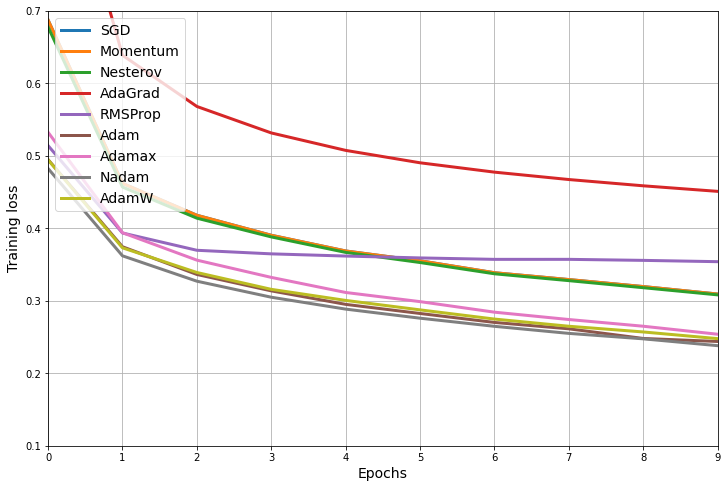

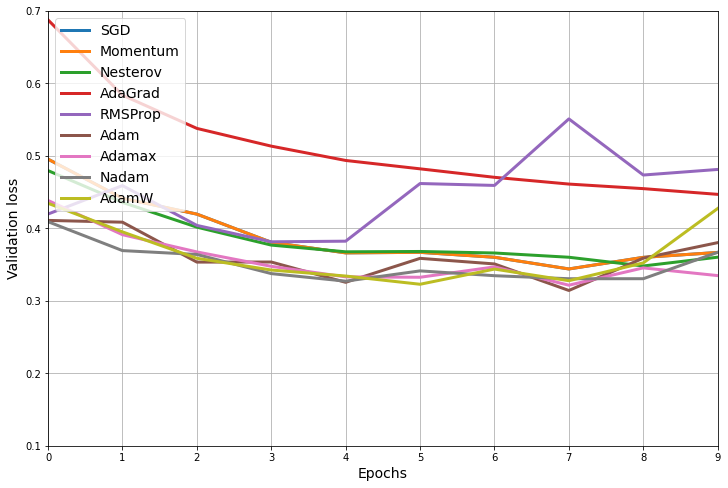

In [36]:
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

In [37]:
#learning scheduling

#power scheduling
# lr = lr0 / (1 + steps / s)**c
# Keras uses c=1 and s = 1 / decay

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)
history_power_scheduling = build_and_train_model(optimizer)


Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6818 - accuracy: 0.7678 - val_loss: 0.4840 - val_accuracy: 0.8276
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4702 - accuracy: 0.8361 - val_loss: 0.4421 - val_accuracy: 0.8398
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4241 - accuracy: 0.8491 - val_loss: 0.4110 - val_accuracy: 0.8530
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4011 - accuracy: 0.8579 - val_loss: 0.3899 - val_accuracy: 0.8578
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3820 - accuracy: 0.8638 - val_loss: 0.3839 - val_accuracy: 0.8616
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3683 - accuracy: 0.8691 - val_loss: 0.3830 - val_accuracy: 0.8618
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3579 - accuracy: 0.8709 - val_loss: 0.3719 - val_accuracy:

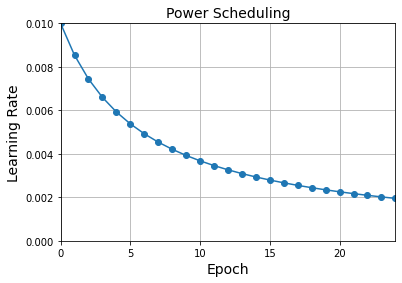

In [38]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
n_epochs = 25

epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [39]:
# Exponential Scheduling
# lr = lr0 * 0.1 ** (epoch / s)

def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)


#build and compile a model for Fashion MNIST

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6795 - accuracy: 0.7682 - val_loss: 0.4782 - val_accuracy: 0.8314 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4656 - accuracy: 0.8375 - val_loss: 0.4393 - val_accuracy: 0.8410 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4191 - accuracy: 0.8508 - val_loss: 0.4111 - val_accuracy: 0.8550 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3947 - accuracy: 0.8601 - val_loss: 0.3853 - val_accuracy: 0.8602 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3748 - accuracy: 0.8668 - val_loss: 0.3764 - val_accuracy: 0.8624 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3604 - accuracy: 0.8716 - val_loss: 0.3792 - val_accuracy: 0.8636 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 4s

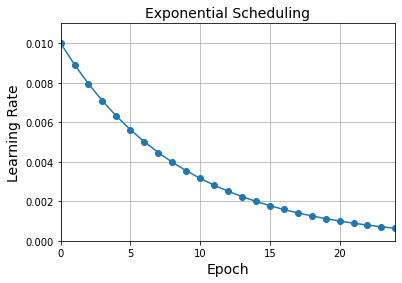

In [40]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [41]:
# The schedule function can take the current learning rate as a second argument:

def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

# if you want to update the learning rate at each iteration rather than at each epoch, you can write your own callback class:
K = tf.keras.backend

class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

n_epochs = 25
batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])


Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6804 - accuracy: 0.7679 - val_loss: 0.4808 - val_accuracy: 0.8284 - lr: 0.0091
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4684 - accuracy: 0.8359 - val_loss: 0.4421 - val_accuracy: 0.8386 - lr: 0.0083
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4218 - accuracy: 0.8484 - val_loss: 0.4127 - val_accuracy: 0.8528 - lr: 0.0076
Epoch 4/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3974 - accuracy: 0.8590 - val_loss: 0.3865 - val_accuracy: 0.8602 - lr: 0.0069
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3773 - accuracy: 0.8655 - val_loss: 0.3791 - val_accuracy: 0.8630 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3629 - accuracy: 0.8712 - val_loss: 0.3786 - val_accuracy: 0.8630 - lr: 0.0058
Epoch 7/25
1719/1719 [==============================] - 8s

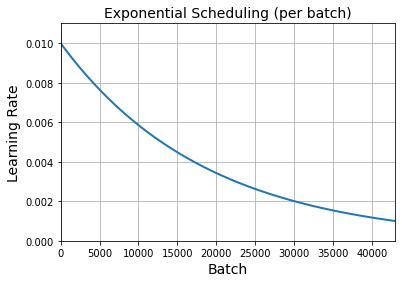

In [42]:
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
steps = np.arange(n_steps)
decay_rate = 0.1
lrs = lr0 * decay_rate ** (steps / n_steps)

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

In [43]:
# Piecewise Constant Scheduling
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001
# extra code – this cell demonstrates a more general way to define
#              piecewise constant scheduling.

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])
n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])


Epoch 1/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5716 - accuracy: 0.7983 - val_loss: 0.4669 - val_accuracy: 0.8238 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4513 - accuracy: 0.8406 - val_loss: 0.4377 - val_accuracy: 0.8396 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4335 - accuracy: 0.8476 - val_loss: 0.4737 - val_accuracy: 0.8420 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4203 - accuracy: 0.8552 - val_loss: 0.4263 - val_accuracy: 0.8484 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4019 - accuracy: 0.8596 - val_loss: 0.4245 - val_accuracy: 0.8478 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3520 - accuracy: 0.8749 - val_loss: 0.3851 - val_accuracy: 0.8654 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 8

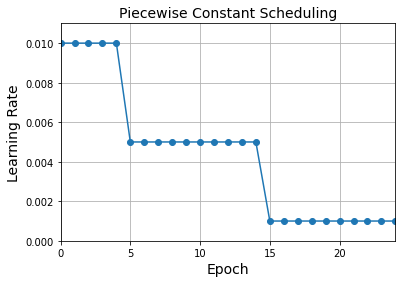

In [44]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [45]:
# Performance Scheduling
# extra code – build and compile the model

model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6795 - accuracy: 0.7682 - val_loss: 0.4782 - val_accuracy: 0.8314 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4670 - accuracy: 0.8369 - val_loss: 0.4444 - val_accuracy: 0.8402 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4193 - accuracy: 0.8502 - val_loss: 0.4135 - val_accuracy: 0.8540 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3939 - accuracy: 0.8597 - val_loss: 0.3813 - val_accuracy: 0.8604 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3715 - accuracy: 0.8676 - val_loss: 0.3673 - val_accuracy: 0.8680 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3553 - accuracy: 0.8728 - val_loss: 0.3749 - val_accuracy: 0.8674 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================] - 5s

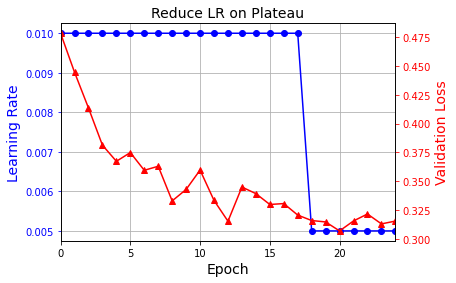

In [46]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

In [47]:
import math

batch_size = 32
n_epochs = 25
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
scheduled_learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=n_steps, decay_rate=0.1)
optimizer = tf.keras.optimizers.SGD(learning_rate=scheduled_learning_rate)

# extra code – build and train the model
model = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6809 - accuracy: 0.7678 - val_loss: 0.4822 - val_accuracy: 0.8276
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4691 - accuracy: 0.8367 - val_loss: 0.4402 - val_accuracy: 0.8410
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4225 - accuracy: 0.8495 - val_loss: 0.4128 - val_accuracy: 0.8522
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3983 - accuracy: 0.8592 - val_loss: 0.3868 - val_accuracy: 0.8592
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3779 - accuracy: 0.8656 - val_loss: 0.3769 - val_accuracy: 0.8632
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3635 - accuracy: 0.8703 - val_loss: 0.3791 - val_accuracy: 0.8642
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3519 - accuracy: 0.8734 - val_loss: 0.3669 - val_accuracy:

In [48]:
scheduled_learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

In [49]:
# 1Cycle scheduling
# The ExponentialLearningRate custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant factor. It also saves the
# learning rate and loss at each batch. Since logs["loss"] is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must
# compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the
# current batch's loss.

K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

# The find_learning_rate() function trains the model using the ExponentialLearningRate callback, and it returns the learning rates and corresponding batch losses. At
# the end, it restores the model and its optimizer to their initial state.

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

# The plot_lr_vs_loss() function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()


430/430 [==============================] - 3s 6ms/step - loss: 1.8117 - accuracy: 0.4107


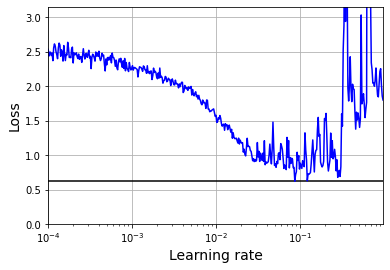

In [50]:
#lets build a fasion mnist
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [51]:
# The OneCycleScheduler custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate
# linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 3s 6ms/step - loss: 0.9502 - accuracy: 0.6913 - val_loss: 0.6003 - val_accuracy: 0.7874
Epoch 2/25
430/430 [==============================] - 3s 7ms/step - loss: 0.5695 - accuracy: 0.8024 - val_loss: 0.4931 - val_accuracy: 0.8254
Epoch 3/25
430/430 [==============================] - 3s 7ms/step - loss: 0.4955 - accuracy: 0.8254 - val_loss: 0.4721 - val_accuracy: 0.8282
Epoch 4/25
430/430 [==============================] - 3s 8ms/step - loss: 0.4509 - accuracy: 0.8401 - val_loss: 0.4263 - val_accuracy: 0.8490
Epoch 5/25
430/430 [==============================] - 3s 6ms/step - loss: 0.4222 - accuracy: 0.8489 - val_loss: 0.4071 - val_accuracy: 0.8470
Epoch 6/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3960 - accuracy: 0.8573 - val_loss: 0.4915 - val_accuracy: 0.8148
Epoch 7/25
430/430 [==============================] - 4s 8ms/step - loss: 0.3777 - accuracy: 0.8633 - val_loss: 0.3924 - val_accuracy: 0.8578
Epoch 

In [52]:
#avoiding overfitting through regularization
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))
# Or use l1(0.1) for ℓ1 regularization with a factor of 0.1, or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively.
tf.random.set_seed(42)


In [53]:
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

In [54]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 3.1224 - accuracy: 0.7748 - val_loss: 1.8602 - val_accuracy: 0.8264
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 1.4263 - accuracy: 0.8158 - val_loss: 1.1267 - val_accuracy: 0.8192


In [55]:
tf.random.set_seed(42)

In [56]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [57]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.6703 - accuracy: 0.7536 - val_loss: 0.4498 - val_accuracy: 0.8342
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5104 - accuracy: 0.8135 - val_loss: 0.4312 - val_accuracy: 0.8306
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4711 - accuracy: 0.8257 - val_loss: 0.3842 - val_accuracy: 0.8570
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4496 - accuracy: 0.8341 - val_loss: 0.3710 - val_accuracy: 0.8616
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4338 - accuracy: 0.8408 - val_loss: 0.3676 - val_accuracy: 0.8590
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4230 - accuracy: 0.8437 - val_loss: 0.3750 - val_accuracy: 0.8610
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4131 - accuracy: 0.8464 - val_loss: 0.3569 - val_accuracy

In [58]:
model.evaluate(X_train, y_train)

1719/1719 [==============================] - 3s 2ms/step - loss: 0.3119 - accuracy: 0.8835


[0.31187698245048523, 0.88350909948349]

In [59]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3675 - accuracy: 0.8702


[0.3674687147140503, 0.870199978351593]

In [60]:
#mc dropout
tf.random.set_seed(42)
y_probas = np.stack([model(X_test, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)


In [61]:
model.predict(X_test[:1]).round(3)

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.019, 0.   , 0.096, 0.   ,
        0.885]], dtype=float32)

In [62]:
y_proba[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.092, 0.   , 0.15 , 0.   ,
       0.757], dtype=float32)

In [63]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.117, 0.001, 0.146, 0.001,
       0.181], dtype=float32)

In [64]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.8706

In [65]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

In [66]:
# extra code – shows how to convert Dropout to MCDropout in a Sequential model
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])
mc_model.set_weights(model.get_weights())

In [67]:
mc_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_21 (Flatten)        (None, 784)               0         
                                                                 
 mc_dropout (MCDropout)      (None, 784)               0         
                                                                 
 dense_85 (Dense)            (None, 100)               78500     
                                                                 
 mc_dropout_1 (MCDropout)    (None, 100)               0         
                                                                 
 dense_86 (Dense)            (None, 100)               10100     
                                                                 
 mc_dropout_2 (MCDropout)    (None, 100)               0         
                                                                 
 dense_87 (Dense)            (None, 10)              

In [68]:
# extra code – shows that the model works without retraining
tf.random.set_seed(42)
np.mean([mc_model.predict(X_test[:1])
         for sample in range(100)], axis=0).round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.12, 0.  , 0.78]],
      dtype=float32)

In [69]:
#Max norm
dense = tf.keras.layers.Dense(
    100, activation="relu", kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.))

In [70]:
# extra code – shows how to apply max norm to every hidden layer in a model

MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="relu", kernel_initializer="he_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5500 - accuracy: 0.8015 - val_loss: 0.4510 - val_accuracy: 0.8242
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4085 - accuracy: 0.8507 - val_loss: 0.3997 - val_accuracy: 0.8488
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3778 - accuracy: 0.8613 - val_loss: 0.3749 - val_accuracy: 0.8672
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3583 - accuracy: 0.8696 - val_loss: 0.3498 - val_accuracy: 0.8734
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3419 - accuracy: 0.8729 - val_loss: 0.3544 - val_accuracy: 0.8656
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3369 - accuracy: 0.8764 - val_loss: 0.3797 - val_accuracy: 0.8644
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3296 - accuracy: 0.8761 - val_loss: 0.4116 - val_accuracy: